# Classification Sarkasme using GRU
## Importing libraries

In [ ]:
import json
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from collections import Counter

In [ ]:
# --- Load Dataset ---
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json"
data = [json.loads(line) for line in requests.get(url).text.strip().split('\n')]
sentences = [item['headline'] for item in data]
labels = [item['is_sarcastic'] for item in data]

In [ ]:
# --- Preprocessing ---
tokenized = [s.lower().split() for s in sentences]
vocab = {w: i+2 for i, (w, _) in enumerate(Counter([w for sent in tokenized for w in sent]).most_common())}
vocab['<PAD>'] = 0
vocab['<OOV>'] = 1

MAX_LEN = 40
def encode(sent):
    ids = [vocab.get(w, vocab['<OOV>']) for w in sent]
    return ids + [vocab['<PAD>']]*(MAX_LEN - len(ids)) if len(ids) < MAX_LEN else ids[:MAX_LEN]

X = torch.tensor([encode(s) for s in tokenized])
y = torch.tensor(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# --- Dataset & DataLoader ---
class SarcasmDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SarcasmDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(SarcasmDataset(X_test, y_test), batch_size=64)


In [ ]:
# --- GRU Model ---
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h = self.gru(x)
        h = torch.cat((h[-2], h[-1]), dim=1)
        return self.sigmoid(self.fc(self.dropout(h))).squeeze()


In [ ]:
# --- Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUModel(len(vocab), 200, 256).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(10):
    model.train()
    train_loss, correct = 0, 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.float().to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward(); optimizer.step()
        train_loss += loss.item()
        correct += (out > 0.5).int().eq(yb.int()).sum().item()

    train_acc = correct / len(X_train)
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc)

    model.eval()
    correct, total_loss, all_probs, all_preds, all_labels = 0, 0, [], [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.float().to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            total_loss += loss.item()
            probs = out.cpu().numpy()
            preds = (probs > 0.5).astype(int)
            correct += (preds == yb.cpu().numpy()).sum()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(yb.cpu().numpy())

    test_losses.append(total_loss / len(test_loader))
    test_acc = correct / len(X_test)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")



Epoch 1: Train Loss = 0.5238, Test Loss = 0.4608, Train Acc = 0.7239, Test Acc = 0.7748
Epoch 2: Train Loss = 0.4052, Test Loss = 0.4248, Train Acc = 0.8080, Test Acc = 0.8046
Epoch 3: Train Loss = 0.3260, Test Loss = 0.4032, Train Acc = 0.8563, Test Acc = 0.8186
Epoch 4: Train Loss = 0.2520, Test Loss = 0.3920, Train Acc = 0.8957, Test Acc = 0.8287
Epoch 5: Train Loss = 0.1864, Test Loss = 0.4425, Train Acc = 0.9271, Test Acc = 0.8240
Epoch 6: Train Loss = 0.1197, Test Loss = 0.4815, Train Acc = 0.9568, Test Acc = 0.8272
Epoch 7: Train Loss = 0.0703, Test Loss = 0.5793, Train Acc = 0.9762, Test Acc = 0.8289
Epoch 8: Train Loss = 0.0423, Test Loss = 0.6970, Train Acc = 0.9869, Test Acc = 0.8207
Epoch 9: Train Loss = 0.0260, Test Loss = 0.7164, Train Acc = 0.9924, Test Acc = 0.8242
Epoch 10: Train Loss = 0.0227, Test Loss = 0.7911, Train Acc = 0.9937, Test Acc = 0.8259


In [ ]:
# --- Metrics ---
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

train_final_acc = train_accs[-1] * 100
test_final_acc = test_accs[-1] * 100

print(f"\nFinal Accuracy (Scikit-learn): {acc*100:.2f}%")
print(f"Training Accuracy: {train_final_acc:.2f}%")
print(f"Testing Accuracy: {test_final_acc:.2f}%")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1: {f1:.2f}")
print(f"AUC: {auc:.2f}")


Final Accuracy (Scikit-learn): 82.59%
Training Accuracy: 99.37%
Testing Accuracy: 82.59%
Precision: 0.80
Recall: 0.80
F1: 0.80
AUC: 0.91


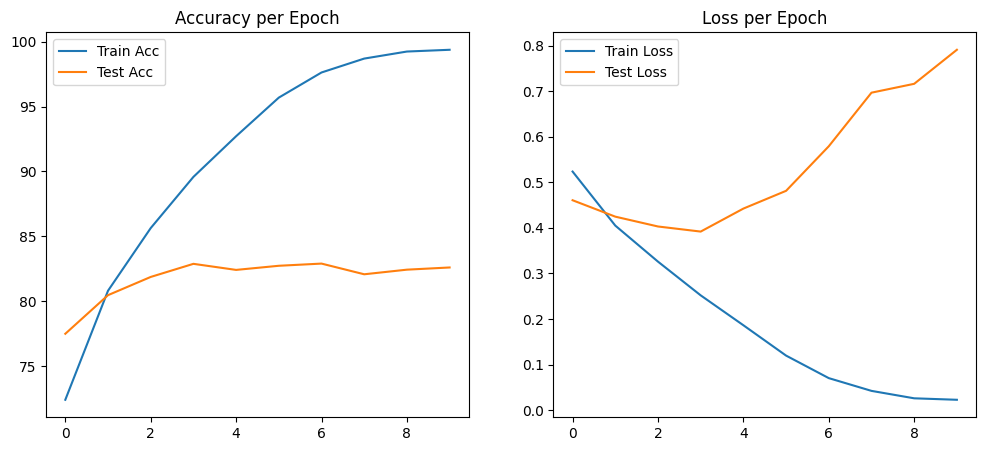

In [ ]:
# --- Accuracy & Loss Plots ---
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(np.array(train_accs)*100, label='Train Acc')
plt.plot(np.array(test_accs)*100, label='Test Acc')
plt.title("Accuracy per Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss per Epoch")
plt.legend()
plt.show()

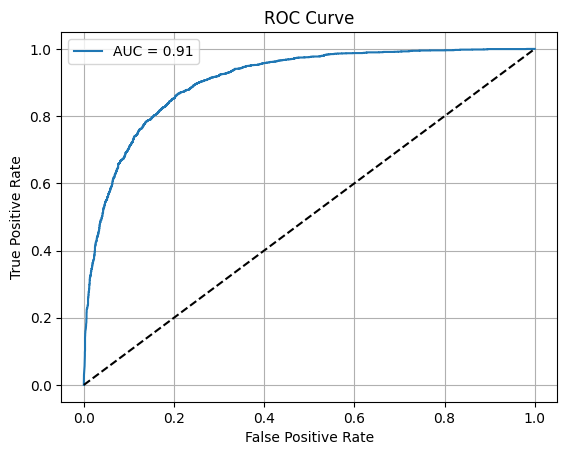

In [ ]:
# --- ROC Curve ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

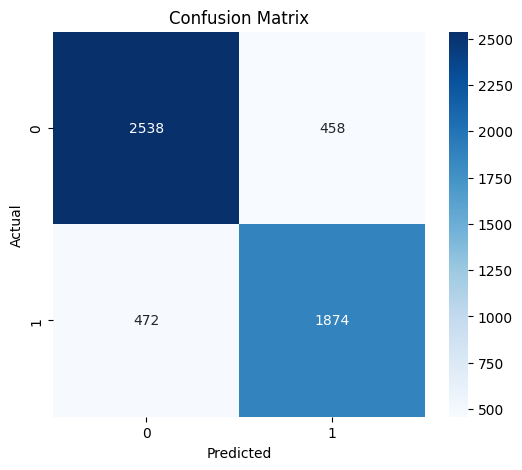

In [ ]:
# --- Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()